# Explore NLP against my journal entries

This notebook allows me to play with NLP concepts using my personal journals.
I've been writing personal journal entries ala 750 words a day for several years.

In [1]:
"""
from sklearn.datasets import fetch_openml
from sklearn import datasets, svm, metrics
from pandas import DataFrame
import matplotlib as mpl
"""

from typing import List, Tuple
from dataclasses import dataclass
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import glob
import os
from pathlib import Path

# get nltk and corpus
import nltk
from nltk.corpus import stopwords

# get scapy and corpus
import spacy
import time
from functools import lru_cache
from matplotlib import animation, rc
from IPython.display import HTML
from datetime import timedelta
import itertools
import importlib
import igor_journal
from datetime import date

# python won't reload an already imported library
# since co-editting files in another directory, need to do a reload
importlib.reload(igor_journal)
from icecream import ic

In [2]:
# This function is in the first block so you don't
# recreate it willy nilly, as it includes a cache.

nltk.download("stopwords")


@lru_cache(maxsize=4)
def get_nlp_model(model: str):
    start_time = time.time()
    print(f"Loading Model {model}")
    nlp = spacy.load(model)  # python -m spacy download en_core_web_lg
    spacy.prefer_gpu()  # This will be cool if/when it happens.
    duration = time.time() - start_time
    print(f"Took: {int(duration)}")
    return nlp

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/idvorkin_home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Build corpus from my journal in igor2/750words

In [3]:
# make the plot wider
height_in_inches = 8
matplotlib.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

### Load simple corpus for my journal

In [4]:
start = date (2022,2,1)
delta_days = 180
corpus = igor_journal.LoadCorpus(before=start + timedelta(days=delta_days),  after=start)

print(f"initial words {len(corpus.initial_words)} remaining words {len(corpus.words)}")

initial words 12661 remaining words 6017


In [6]:
# Could use nltk frequency distribution plot, but better off building our own.
# fd = nltk.FreqDist(words)
# fd.plot(50, percents=True)
# Can also use scikit learn CountVectorizor

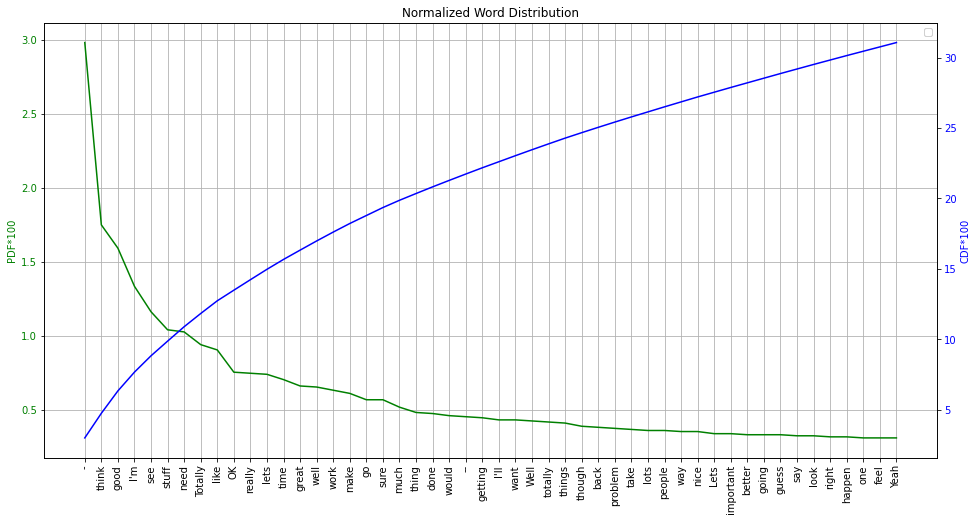

In [7]:
# Same as NLTK FreqDist, except normalized, includes cumsum, and colors
def GraphWordDistribution(words, title="", skip=0, length=50, includeCDF=True) -> None:
    def GetPDFCDF(words):
        def ToPercent(x: float) -> float:
            return x * 100

        # NOTE: No point creating a full data frame when only using a single column.
        pdf = pd.Series(words).value_counts(normalize=True).apply(ToPercent)
        cdf = pdf.cumsum()
        return (pdf, cdf)

    def PlotOnAxis(series, ax, label: str, color: str):
        # RANT: Why is MPL so confusing? The OO interface vs the stateful interface, GRAH!!
        # The random non-obvious calls.
        # GRAH!!!

        ax.legend(label.split())
        ax.plot(series, color=color)

        # RANT: Why no YAxis.set_labal_params()? E.g.
        #                 ax.yaxis.set_label_params(label, color=color)
        ax.set_ylabel(label, color=color)
        ax.yaxis.set_tick_params(labelcolor=color)

        # technically all the X axis paramaters are duplicated since we "twinned the X paramater"
        ax.xticks = range(len(series))

        # RANT: rot can be set on plt.plot(), but not on axes.plot()
        ax.xaxis.set_tick_params(rotation=90)

    # NOTE: can make graph prettier with styles E.g.
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(1)

    ax.set_title(title)
    ax.grid(True)

    # make pdf first axes, and cdf second axes.
    ax_pdf, ax_cdf = (ax, ax.twinx())
    color_pdf, color_cdf = ("green", "blue")
    pdf, cdf = GetPDFCDF(words)

    PlotOnAxis(pdf[skip : skip + length], ax_pdf, label="PDF*100", color=color_pdf)
    PlotOnAxis(cdf[skip : skip + length], ax_cdf, label="CDF*100", color=color_cdf)


GraphWordDistribution(corpus.words, title="Normalized Word Distribution")

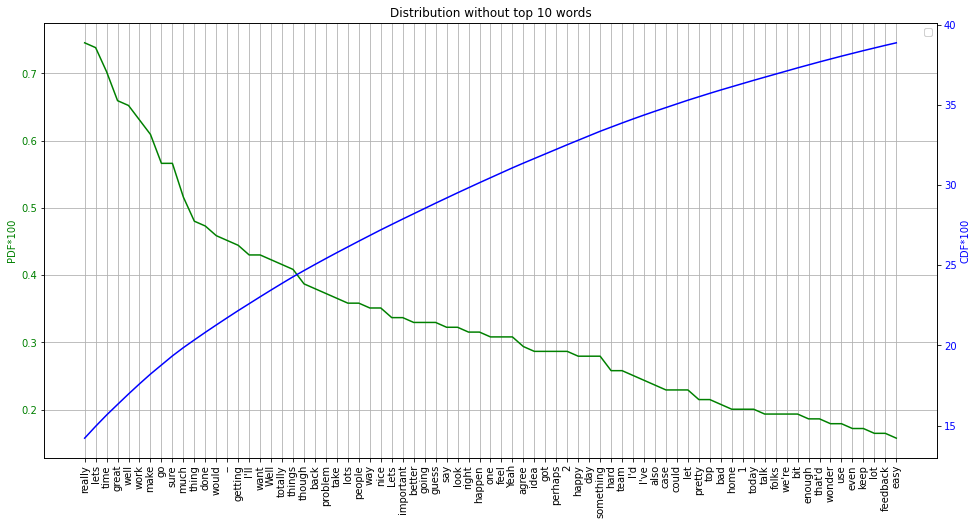

In [8]:
skip = 10
GraphWordDistribution(
    corpus.words, skip=skip, length=75, title=f"Distribution without top {skip} words"
)

In [9]:
# wordcloud is non-deterministic, which is bizarre.
# from wordcloud import WordCloud
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=None).generate("".join(words))
# plt.imshow(wordcloud,  interpolation='bilinear')

# Play with POS tagging and lemmatisation

In [7]:
# !python -m spacy download en_core_web_lg
#!python3 -m spacy download en_core_web_trf
from igor_journal import Corpus, LoadCorpus, DocForCorpus

nlp = get_nlp_model("en_core_web_trf")

nlp.max_length = 100 * 1000 * 1000


def GetInterestingWords(pos: str, doc=None, corpus: Corpus = None):
    interesting_pos = pos
    _, doc_all = DocForCorpus(nlp, corpus)

    interesting_pos_set = set(interesting_pos.split())
    interesting = [token for token in doc_all if hasattr(token, "pos_") and token.pos_ in interesting_pos_set]
    interesting_words = [token.lemma_ for token in interesting]
    return interesting_words


def GraphPoSForDoc(pos: str, doc=None, corpus=None):

    GraphWordDistribution(
        GetInterestingWords(pos, doc, corpus=corpus),
        title=f"Distribution of {pos} on {corpus.date_range}",
        skip=0,
        length=20,
    )


def GraphScratchForCorpus(pos: str = "NOUN VERB ADJ ADV", corpus: Corpus = None):
    doc = DocForCorpus(nlp, corpus)
    GraphPoSForDoc(pos, doc, corpus)

Loading Model en_core_web_trf
Took: 4


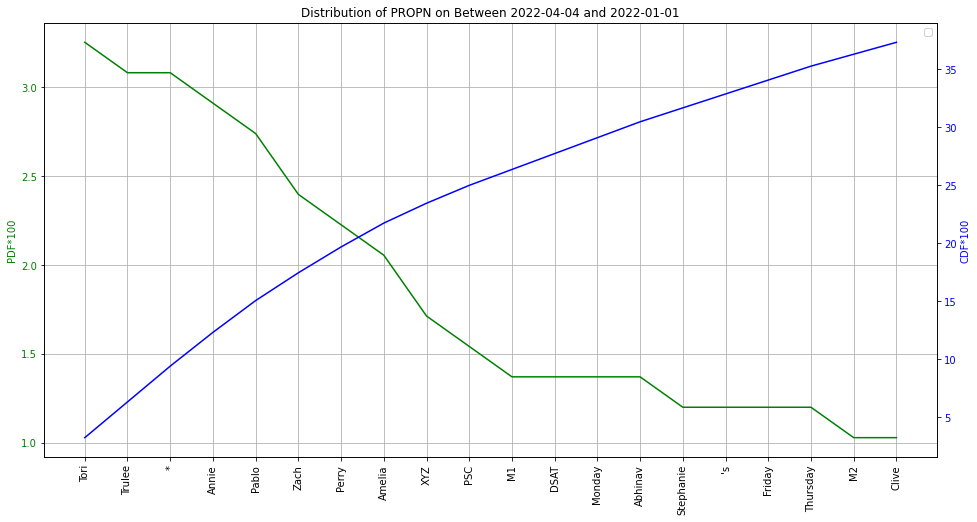

In [23]:
GraphScratchForCorpus(pos="PROPN", corpus=corpus)

In [10]:
start = date (2020,8,1)
delta_days = 30
corpus = LoadCorpus(before=start + timedelta(days=delta_days),  after=start)
all_words, doc  = DocForCorpus(nlp, corpus)
import pandas as pd
pd.set_option('display.max_rows', 40)
pd.set_option('display.min_rows', 20)

display (list(doc)[0].pos_)

df = pd.DataFrame([(e.text, e.label_, 1) for e in doc.ents], columns=["Text","Label","One"]) 
df = df[~df.Text.isin(["Yup"])]
df = df[~df.Label.isin(["DATE","CARDINAL","TIME", "ORDINAL", "PERCENT", "QUANTITY", "MONEY"])]
display (df[df.Text=="Yup"]) # debug bad parses
df = df.groupby([df.Text, df.Label]).count().reset_index().sort_values("One",ascending=False) 
df = df[df.One > 1] # throw away entries that are too small
display ("People",df) 

df = pd.DataFrame([(token.lemma_, token.pos_, 1) for token in doc if token.pos_ == "NOUN"], columns=["Text","Label","One"]) 
df = df[~df.Text.isin(["Yup"])]
df = df[~df.Label.isin(["DATE","CARDINAL","TIME", "ORDINAL", "PERCENT", "QUANTITY", "MONEY"])]
display (df[df.Text=="Yup"]) # debug bad parses
df = df.groupby([df.Text, df.Label]).count().reset_index().sort_values("One",ascending=False) 
df = df[df.One > 1][30:90] # throw away entries that are too small
display ("People",df) 



list(doc)[25]

'AUX'

,Text,Label,One


'People'

,Text,Label,One
24,Zach,PERSON,6
19,Totlaly,PERSON,4
17,Tori,PERSON,3
9,Joe,PERSON,3
1,Amelia,PERSON,2
13,Pablo,PERSON,2
21,Wlel,PERSON,2


,Text,Label,One


'People'

,Text,Label,One
80,bunch,NOUN,8
286,home,NOUN,7
342,lens,NOUN,7
391,monitor,NOUN,7
587,side,NOUN,7
573,sense,NOUN,7
93,case,NOUN,6
710,view,NOUN,6
708,video,NOUN,6
649,tech,NOUN,6


well

# Debugging when stuff goes goofy.

In [48]:
_ = """
max_to_analyze = 15
interesting = [token for token in doc if token.tag_ == "NNS"]
for token in interesting[:max_to_analyze]:
    # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

# Parts of speech: https://spacy.io/usage/linguistic-features
GraphWordDistribution([token.pos_ for token in doc], title=f"POS Distribution on {corpus_path}")
# interesting = [ token for token in doc if token.pos_ != "PUNCT" and token.pos_ != "SYM" and len(token.text) > 3]
"""

### Visualizing the "Thought Distribution" over time.
* A] Sentiment over time. Graph valence as line graph time series
    (TBD: Use cloud service to analyze each file)

* B] Graph a bar chart of Proper noun trending over time, have it update per corpus file.
 * Build a data frame of word frequency "Proper Noun"x"Corpus"
 * Graph update every second.

In [11]:
def MakePDF(words, name):
    def ToPercent(x: float) -> float:
        return x * 100

    return pd.Series(words, name=name).value_counts(normalize=True).apply(ToPercent)


def PathToFriendlyTitle(path: str):
    path = path.split("/")[-1]
    if "export-" in path:
        return path.split("export-")[-1]
    else:
        return path

In [13]:
# importlib.reload(igor_journal)
import ray
ray.init(num_cpus=12) # leave four CPUs for my machine. 

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2022-04-03_16-33-03_002630_88581/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-04-03_16-33-03_002630_88581/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-04-03_16-33-03_002630_88581',
 'metrics_export_port': 61034,
 'gcs_address': '127.0.0.1:61727',
 'address': '127.0.0.1:61727',
 'node_id': 'e57f017e0c687407b1ec7b159796dc940e20b0398ff1fa0e9fc85864'}

In [ ]:
nlp_ref = ray.put(nlp)
from datetime import datetime
# ray.shutdown()

@ray.remote
def parallelDocForCorpus(before, after):
    doc, doc_all = DocForCorpus(ray.get(nlp_ref), LoadCorpus(before,after))
    return doc_all

count_months = 1 * 6
doc_promises = [
            parallelDocForCorpus.remote(
                before=datetime.now().date() - timedelta(days=30 * i - 30),
                after=datetime.now().date() - timedelta(days=30 * i),
            )
    for i in range(count_months, 0, -1)
]
# doesn't matter the order we block on since we need all of them to complete
docs = [ray.get(d) for d in  doc_promises]

(parallelDocForCorpus pid=89872) ++ Building corpus Between 2021-12-04 and 2021-11-04 len:3271 
(parallelDocForCorpus pid=89871) ++ Building corpus Between 2022-01-03 and 2021-12-04 len:3080 
(parallelDocForCorpus pid=89866) ++ Building corpus Between 2021-11-04 and 2021-10-05 len:14197 
(parallelDocForCorpus pid=89868) ++ Building corpus Between 2022-04-03 and 2022-03-04 len:0 
(parallelDocForCorpus pid=89868) -- [0s]: Building corpus Between 2022-04-03 and 2022-03-04 len:0 
(parallelDocForCorpus pid=89869) ++ Building corpus Between 2022-02-02 and 2022-01-03 len:81434 
(parallelDocForCorpus pid=89867) ++ Building corpus Between 2022-03-04 and 2022-02-02 len:60589 
(parallelDocForCorpus pid=89872) -- [4s]: Building corpus Between 2021-12-04 and 2021-11-04 len:3271 
(parallelDocForCorpus pid=89871) -- [4s]: Building corpus Between 2022-01-03 and 2021-12-04 len:3080 
(parallelDocForCorpus pid=89866) -- [17s]: Building corpus Between 2021-11-04 and 2021-10-05 len:14197 


In [53]:
top_words_to_skip, count_words = 0, 20
pdfs = [
    MakePDF(
        GetInterestingWords(
            "PROPN",
            corpus=LoadCorpus(
                before=datetime.datetime.now().date() - timedelta(days=30 * i - 30),
                after=datetime.datetime.now().date() - timedelta(days=30 * i),
            ),
        ),
        f"{datetime.datetime.now().date()-timedelta(days=30*i)}",
    )
    for doc in range(count_months, 0, -1)
]

# TODO: Why can't we use the join - gives an error.
# wordByTimespan = pd.DataFrame().join(pdfs, how="outer", sort=False)
wordByTimespan = pd.DataFrame()
for pdf in pdfs:
    wordByTimespan = wordByTimespan.join(pdf, how="outer")

# Sort by sum(word frequency) over all corpus
# I  suspect it'd be interesting to sort by TF*IDF because it'll make words that are present
# only in a few months get a boost.
wordByTimespan["word_frequency"] = wordByTimespan.sum(skipna=True, axis="columns")
wordByTimespan = wordByTimespan.sort_values("word_frequency", ascending=False)


# Remove total column
wordByTimespan = wordByTimespan.iloc[:, :-1]

print(f"skipping:{top_words_to_skip}, count:{count_words} ")

# wordByTimespan.iloc[:50, :].plot( kind="bar", subplots=False, legend=False, figsize=(15, 14), sharey=True )
wordByTimespan.iloc[top_words_to_skip : top_words_to_skip + count_words, :].T.plot(
    kind="bar", subplots=True, legend=False, figsize=(15, 9), sharey=True
)
# wordByTimespan.iloc[:13, :].T.plot( kind="bar", subplots=False, legend=True, figsize=(15, 14), sharey=True )

initial words 10138 remaining words 4771
++ Building corpus of len:51866 


KeyboardInterrupt: 

In [ ]:
top_words_to_skip, count_words = 5, 20
top_word_by_year = wordByTimespan.iloc[
    top_words_to_skip : top_words_to_skip + count_words, :
][::-1]
# top_word_by_year = wordByTimespan.iloc[:15,:][::-1] # the -1 on the end reverse the count

anim_fig_size = (16, 20)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = top_word_by_year.iloc[:, 0].plot(
    title=f"Title Over Written", figsize=anim_fig_size, kind="barh"
)

animation.patches = ax.patches
loop_colors = itertools.cycle("bgrcmk")
animation.colors = list(itertools.islice(loop_colors, len(animation.patches)))


def animate(
    i,
):
    # OMG: That was impossible to find!!!
    # Turns out every time you call plot, more patches (bars) are added to graph.  You need to remove them, which is very non-obvious.
    # https://stackoverflow.com/questions/49791848/matplotlib-remove-all-patches-from-figure
    [p.remove() for p in reversed(animation.patches)]
    top_word_by_year.iloc[:, i].plot(
        title=f"Distribution {top_word_by_year.columns[i]}",
        kind="barh",
        color=animation.colors,
        xlim=(0, 10),
    )
    return (animation.patches,)


anim = animation.FuncAnimation(
    fig,
    animate,
    frames=len(top_word_by_year.columns),
    interval=timedelta(seconds=1).seconds * 1000,
    blit=False,
)
HTML(anim.to_html5_video())

In [ ]:
dmo = """
corpus_path = "~/gits/igor2/750words/2019-06-*md"
corpus = LoadCorpus(corpus_path)
doc = DocForCorpus(nlp, corpus)
for t in doc[400:600]:
print(f"{t} {t.lemma_} {t.pos_}")
"""
from spacy import displacy

displacy.render(nlp("Igor wonders if Ray is working too much"))